In [1]:
#ライブラリのimport
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import time
import shutil
import shap
import locale
import seaborn as sns
import matplotlib as mpl
from dateutil.relativedelta import relativedelta
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from datetime import datetime
from PIL import Image

/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', co

In [88]:
#生データのパス
folder_path_zaikoMB = '生データ/在庫推移MB'
folder_path_LTMB = '生データ/所在管理MB'
folder_path_kumitate = '生データ/組立実績MB'
folder_path_tehaisu = '生データ/手配必要数'
folder_path_tehaiunyo = '生データ/手配運用情報'
folder_path_pitch = '生データ/不等ピッチ係数'
folder_path_kotei = '生データ/使用工程'
#中間成果物のパス
folder_path_interproduct = '中間成果物'
file_path_zaikodata = '中間成果物/在庫推移MBデータ_統合済.csv'
file_path_LTdata = '中間成果物/所在管理MBデータ_統合済.csv'
file_path_kumitate = '中間成果物/組立実績MBデータ_統合済.csv'
file_path_pitch = '中間成果物/不等ピッチデータ_統合済.csv'
file_path_kotei = '中間成果物/使用工程データ_統合済.csv'
file_path_date= '中間成果物/日付ファイル_開始日と終了日記載.txt'
file_path_zaikodata_extract = '中間成果物/在庫推移MBデータ_統合済&特定日時抽出済.csv'
file_path_LTdata_extract = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済.csv'
file_path_kumitate_extract = '中間成果物/組立実績MBデータ_統合済&特定日時抽出済.csv'
file_path_tehaisu_with_tehaiunyo = '中間成果物/手配数データ_手配運用情報統合済'#.csvいらない
#新規追加
file_path_kanban_count_data_by_hour = '中間成果物/単位時間当たりのかんばん数データ.csv'
file_path_kanban_count_rackzaiko_data = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量.csv'
file_path_teikibin_count_data_by_hour = '中間成果物/単位時間当たりの荷役時間データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量&荷役時間データ.csv'
file_path_kumitatedaisu_adjusted = '中間成果物/単位時間当たりの組立生産台数データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu = '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量&荷役時間&組立生産台数データ.csv'
file_path_robot_and_maguchi = '中間成果物/ロボット＆間口データ.csv'
file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu_and_robot_and_maguchi = \
  '中間成果物/単位時間当たりのかんばん数&自動ラック在庫データのフラグ＆量&荷役時間&組立生産台数&ロボットと間口データ.csv'
#最終成果物のパス
folder_path_finalproduct = '最終成果物'

In [3]:
start_date_input='2023-10-01'
end_date_input ='2024-03-30'
start_date = pd.to_datetime(start_date_input).date()
end_date = pd.to_datetime(end_date_input).date()

In [28]:
def process_kanbandata_to_generate_kanban_count_data_by_hour(
    file_path, datetime_column, order_quantity_column, start_date=None, end_date=None):
    
    # CSVファイルの読み込み
    data = pd.read_csv(file_path, encoding='shift_jis')

    # 日時カラムを datetime 形式に変換
    data[datetime_column] = pd.to_datetime(data[datetime_column], errors='coerce')

    # 品番ごとに1時間ごとの〇〇かんばん数を集計
    data['YYYYMMDDH'] = data[datetime_column].dt.floor('H')
    hourly_orders = data.groupby(['品番', 'YYYYMMDDH']).size().reset_index(name=order_quantity_column)

    # 1時間前から22時間前の〇〇かんばん数を計算するループ
    for i in range(1, 23):
        hourly_orders[f'{i}時間前の{order_quantity_column}'] = hourly_orders.groupby('品番')[order_quantity_column].shift(i)

    # 対象時間範囲のデータフレームを作成する
    #　　start_data、end_dateが定義されていれば、使用
    min_time = pd.to_datetime(start_date) if start_date else data[datetime_column].min()
    max_time = pd.to_datetime(end_date)   if end_date   else data[datetime_column].max()
    all_times = pd.date_range(start=min_time.floor('H'), end=max_time.ceil('H'), freq='H')

    # 品番ごとに対象時間範囲のデータフレームを作成し、元の集計データとマージする
    product_time_combinations = pd.MultiIndex.from_product([data['品番'].unique(), all_times], names=['品番', 'YYYYMMDDH'])
    full_data = pd.DataFrame(index=product_time_combinations).reset_index()
    full_data = full_data.merge(hourly_orders, on=['品番', 'YYYYMMDDH'], how='left')
    for i in range(1, 23):
        full_data[f'{i}時間前の{order_quantity_column}'] = full_data.groupby('品番')[order_quantity_column].shift(i)
    full_data.fillna(0, inplace=True)  # 一括でNaNを0に変換
    return full_data

datetime_column = '発注日時'
order_quantity_column = '発注かんばん数'
hatyu_data = process_kanbandata_to_generate_kanban_count_data_by_hour(
    file_path_LTdata_extract, datetime_column, order_quantity_column, start_date, end_date)

datetime_column = '検収日時'
order_quantity_column = '納入かんばん数'
nonyu_data = process_kanbandata_to_generate_kanban_count_data_by_hour(
    file_path_LTdata_extract, datetime_column, order_quantity_column, start_date, end_date)
#nonyu_data[nonyu_data['品番'] == '019128GA010'].head(50)
#start_date_temp = pd.Timestamp('2023-10-05')
#end_date_temp = pd.Timestamp('2023-10-06')
#f = nonyu_data[(nonyu_data['YYYYMMDDH'] >= start_date_temp) & (nonyu_data['YYYYMMDDH'] <= end_date_temp)]
#f.head(20)

#統合する
merged_data_for_kanban = pd.merge(hatyu_data, nonyu_data, on=['品番','YYYYMMDDH'], how='left')
merged_data_for_kanban['品番'] = merged_data_for_kanban['品番'].str.replace(r'\s+', '', regex=True)

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_data_by_hour, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_kanban.to_csv(f)

#例表示
merged_data_for_kanban[merged_data_for_kanban['品番'] == '019128GA010'].head(50)

,品番,YYYYMMDDH,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,13時間前の納入かんばん数,14時間前の納入かんばん数,15時間前の納入かんばん数,16時間前の納入かんばん数,17時間前の納入かんばん数,18時間前の納入かんばん数,19時間前の納入かんばん数,20時間前の納入かんばん数,21時間前の納入かんばん数,22時間前の納入かんばん数
95590,019128GA010,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95591,019128GA010,2023-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95592,019128GA010,2023-10-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95593,019128GA010,2023-10-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95594,019128GA010,2023-10-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95595,019128GA010,2023-10-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95596,019128GA010,2023-10-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95597,019128GA010,2023-10-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95598,019128GA010,2023-10-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95599,019128GA010,2023-10-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
#かんばんCSVファイルの読み込み
kanban_count_data = pd.read_csv(file_path_kanban_count_data_by_hour, encoding='shift_jis')

#自動ラックCSVファイルの読み込み
rackzaiko_data = pd.read_csv(file_path_zaikodata_extract, encoding='shift_jis')
rackzaiko_data['在庫増減数'] = rackzaiko_data["入庫数（箱）"] - rackzaiko_data["出庫数（箱）"]
#列名の変更
rackzaiko_data = rackzaiko_data.rename(columns={'計測日時': 'YYYYMMDDH'})

# '品番'が文字列でない場合は文字列に変換
kanban_count_data['品番'] = kanban_count_data['品番'].astype(str)
rackzaiko_data['品番'] = rackzaiko_data['品番'].astype(str)
rackzaiko_data['品番'] = rackzaiko_data['品番'].str.replace(r'\s+', '', regex=True)

# 'YYYYMMDDH' を datetime 型に変換（エラーが出ないようにする）
kanban_count_data['YYYYMMDDH'] = pd.to_datetime(kanban_count_data['YYYYMMDDH'], errors='coerce')
kanban_count_data['YYYYMMDDH'] = kanban_count_data['YYYYMMDDH'].dt.strftime('%Y-%m-%d-%H:%M:%S')
rackzaiko_data['YYYYMMDDH'] = pd.to_datetime(rackzaiko_data['YYYYMMDDH'], errors='coerce')
rackzaiko_data['YYYYMMDDH'] = rackzaiko_data['YYYYMMDDH'].dt.strftime('%Y-%m-%d-%H:%M:%S')

merged_data_for_kanban_and_rackzaiko = pd.merge(kanban_count_data, rackzaiko_data, on=['品番','YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_kanban_and_rackzaiko = merged_data_for_kanban_and_rackzaiko.loc[:, ~merged_data_for_kanban_and_rackzaiko.columns.str.contains('^Unnamed')]
#NaNを含む行を削除
merged_data_for_kanban_and_rackzaiko = merged_data_for_kanban_and_rackzaiko.dropna(subset=['在庫数（箱）'])

merged_data_for_kanban_and_rackzaiko["入庫数（箱）1時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(1)
merged_data_for_kanban_and_rackzaiko["入庫数（箱）2時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(2)
merged_data_for_kanban_and_rackzaiko["入庫数（箱）3時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(3)
merged_data_for_kanban_and_rackzaiko["入庫数（箱）4時間前"]=merged_data_for_kanban_and_rackzaiko["入庫数（箱）"].shift(4)

merged_data_for_kanban_and_rackzaiko["入庫数（箱）合計"] = \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）1時間前"] + \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）2時間前"] + \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）3時間前"] + \
    merged_data_for_kanban_and_rackzaiko["入庫数（箱）4時間前"]

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_kanban_and_rackzaiko.to_csv(f)

#例を表示
#merged_data_for_kanban_and_rackzaiko[merged_data_for_kanban_and_rackzaiko['品番'] == '019128GA010'].head(50)
merged_data_for_kanban_and_rackzaiko.head(50)

,品番,YYYYMMDDH,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,拠点所番地,在庫数（箱）,入庫数（箱）,出庫数（箱）,在庫増減数,入庫数（箱）1時間前,入庫数（箱）2時間前,入庫数（箱）3時間前,入庫数（箱）4時間前,入庫数（箱）合計
8690,9031150A015,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
8691,9031150A015,2023-10-01-01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8692,9031150A015,2023-10-01-02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
8693,9031150A015,2023-10-01-03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
8694,9031150A015,2023-10-01-04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8695,9031150A015,2023-10-01-05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8696,9031150A015,2023-10-01-06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8697,9031150A015,2023-10-01-07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8698,9031150A015,2023-10-01-08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8699,9031150A015,2023-10-01-09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50420,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
def process_kanban_count_data_to_generate_flag_and_sum(df):
    
    order_prefix = '発注'

    # 'X時間前の発注かんばん数'の列を特定
    previous_order_columns = [col for col in df.columns if '時間前の' + order_prefix + 'かんばん数' in col]
    
    # '発注かんばん数'のフラグと量の列を用意
    df[order_prefix + 'かんばん数（フラグ）'] = 0

    # '発注かんばん数' > 1 の場合、フラグを1に設定
    mask_order_greater_than_one = df[order_prefix + 'かんばん数'] > 1
    df.loc[mask_order_greater_than_one, order_prefix + 'かんばん数（フラグ）'] = 1

    # 各'X時間前の発注かんばん数'列に対してフラグ列を用意し、同様に更新
    for col in previous_order_columns:
        flag_col = f'{col}（フラグ）'
        df[flag_col] = 0
        mask_previous_order_greater_than_one = df[col] > 1
        df.loc[mask_previous_order_greater_than_one, flag_col] = 1
    
    # 新しい列「発注量」を初期化
    df[order_prefix + '量'] = 0

    # 「発注かんばん数」を「発注量」に加える
    df[order_prefix + '量'] += df[order_prefix + 'かんばん数']

    # 各「X時間前の発注かんばん数」も「発注量」に加える
    for col in previous_order_columns:
        df[order_prefix + '量'] += df[col]
        
    #------------------------------------------------------------------------------------------------
    
    order_prefix = '納入'
    
    # 'X時間前の発注かんばん数'の列を特定
    previous_order_columns = [col for col in df.columns if '時間前の' + order_prefix + 'かんばん数' in col]
    
    # '発注かんばん数'のフラグと量の列を用意
    df[order_prefix + 'かんばん数（フラグ）'] = 0

    # '発注かんばん数' > 1 の場合、フラグを1に設定
    mask_order_greater_than_one = df[order_prefix + 'かんばん数'] > 1
    df.loc[mask_order_greater_than_one, order_prefix + 'かんばん数（フラグ）'] = 1

    # 各'X時間前の発注かんばん数'列に対してフラグ列を用意し、同様に更新
    for col in previous_order_columns:
        flag_col = f'{col}（フラグ）'
        df[flag_col] = 0
        mask_previous_order_greater_than_one = df[col] > 1
        df.loc[mask_previous_order_greater_than_one, flag_col] = 1
    
    # 新しい列「発注量」を初期化
    df[order_prefix + '量'] = 0

    # 「発注かんばん数」を「発注量」に加える
    df[order_prefix + '量'] += df[order_prefix + 'かんばん数']

    # 各「X時間前の発注かんばん数」も「発注量」に加える
    for col in previous_order_columns:
        df[order_prefix + '量'] += df[col]

    return df

#かんばん＆自動ラックCSVファイルの読み込み
kanban_count_rackzaiko_data = pd.read_csv(file_path_kanban_count_rackzaiko_data, encoding='shift_jis')
# 不要な「Unnamed」列を削除                
kanban_count_rackzaiko_data = kanban_count_rackzaiko_data.loc[:, ~kanban_count_rackzaiko_data.columns.str.contains('^Unnamed')]

# 関数の適用
merged_data_for_flag_and_sum = process_kanban_count_data_to_generate_flag_and_sum(kanban_count_rackzaiko_data)

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum.to_csv(f)

merged_data_for_flag_and_sum.head()

,品番,YYYYMMDDH,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,14時間前の納入かんばん数（フラグ）,15時間前の納入かんばん数（フラグ）,16時間前の納入かんばん数（フラグ）,17時間前の納入かんばん数（フラグ）,18時間前の納入かんばん数（フラグ）,19時間前の納入かんばん数（フラグ）,20時間前の納入かんばん数（フラグ）,21時間前の納入かんばん数（フラグ）,22時間前の納入かんばん数（フラグ）,納入量
0,9031150A015,2023-10-01-00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
1,9031150A015,2023-10-01-01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
2,9031150A015,2023-10-01-02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
3,9031150A015,2023-10-01-03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
4,9031150A015,2023-10-01-04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0


In [36]:
def add_previous_hours_data(df, X):
    """
    データフレームに1時間前からX時間前までの「便合計」のデータ列を追加する関数。

    Args:
    df (DataFrame): 入力データフレーム。
    X (int): 追加する時間の範囲（1時間前からX時間前まで）。

    Returns:
    DataFrame: 更新されたデータフレーム。
    """
    for i in range(1, X + 1):
        df[f'{i}時間前荷役時間'] = df['荷役時間'].shift(i)
    return df

#ファイル読み込み
file_path_teikibin = '定期便.csv'
teikibin_data = pd.read_csv(file_path_teikibin, encoding='shift_jis')

# 日時の列を datetime 型に変換
teikibin_data['JISEKI_DT'] = pd.to_datetime(teikibin_data['JISEKI_DT'])
teikibin_data['JISEKI_DT2'] = pd.to_datetime(teikibin_data['JISEKI_DT2'])
#1時間単位に変換
teikibin_data['定期便到着時刻（1H）'] = pd.to_datetime(teikibin_data['JISEKI_DT']).dt.floor('H')
teikibin_data['定期便出発時刻（1H）'] = pd.to_datetime(teikibin_data['JISEKI_DT2']).dt.floor('H')
# 日時の差を計算
teikibin_data["荷役時間"] = teikibin_data['JISEKI_DT2'] - teikibin_data['JISEKI_DT']

# 各WORK_IDと定期便到着時刻（1H）の組み合わせに対して荷役時間の合計を計算
grouped = teikibin_data.groupby(['WORK_ID', '定期便到着時刻（1H）'])['荷役時間'].sum().reset_index()

# 1時間毎のデータフレームに各WORK_IDごとの「定期便到着時刻（1H）」列を追加する
date_range = pd.date_range(start = start_date, end = end_date, freq='H')

# YYYYMMDDHに全ての時間帯をマッピング
all_hours_df = pd.DataFrame(date_range, columns=['YYYYMMDDH']).set_index('YYYYMMDDH')

# 結果を保存するための空のDataFrameを準備
result_df = all_hours_df.copy()

# 元のデータセットからユニークなWORK_IDを抽出する
unique_work_ids = teikibin_data['WORK_ID'].unique()

for work_id in unique_work_ids:
    # 特定のWORK_IDに対する荷役時間を含む時間帯のデータフレームを抽出
    work_times = grouped[grouped['WORK_ID'] == work_id]
    work_times = work_times.set_index('定期便到着時刻（1H）')
    # 荷役時間を1時間ごとのデータフレームにマージ
    result_df[f'荷役時間_便_{work_id}'] = work_times['荷役時間']

result_df_reset = result_df.reset_index()

# 荷役時間を分単位に変換し、float型で保存するために、Timedeltaを分に変換する処理を行います。
for col in result_df_reset.columns:
    if "便" in col:
        # Timedeltaを分に変換
        result_df_reset[col] = result_df_reset[col].dt.total_seconds() / 60

pattern_columns = result_df_reset.filter(regex='荷役時間_便_[0\d\W]+').columns
print(pattern_columns)

result_df_reset['荷役時間']=result_df_reset[pattern_columns].sum(axis=1)
result_df_reset.fillna(0, inplace=True)  # 一括でNaNを0に変換

# 関数を使用してデータフレームを更新
X = 8  # 1時間前から5時間前までのデータ列を追加
updated_df = add_previous_hours_data(result_df_reset, X)

# 更新されたデータフレームの最初の数行を表示して内容を確認
updated_df.head()

# 統合したデータを新しいCSVファイルに保存
with open(file_path_teikibin_count_data_by_hour, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    result_df_reset.to_csv(f)

# 結果の一部を表示して確認
result_df_reset.head(100)
# 日付範囲に基づいてデータをフィルタリング
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-06')
f = result_df_reset[(result_df_reset['YYYYMMDDH'] >= start_date_temp) & (result_df_reset['YYYYMMDDH'] <= end_date_temp)]
f.head(20)

Index(['荷役時間_便_01', '荷役時間_便_02', '荷役時間_便_03', '荷役時間_便_04', '荷役時間_便_05',
       '荷役時間_便_06', '荷役時間_便_0K'],
      dtype='object')


,YYYYMMDDH,荷役時間_便_01,荷役時間_便_02,荷役時間_便_03,荷役時間_便_04,荷役時間_便_05,荷役時間_便_06,荷役時間_便_0K,荷役時間,1時間前荷役時間,2時間前荷役時間,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,7時間前荷役時間,8時間前荷役時間
96,2023-10-05 00:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450,0.000000
97,2023-10-05 01:00:00,0.0000,0.000000,0.00000,0.0,41.56105,0.000000,0.0,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450
98,2023-10-05 02:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000
99,2023-10-05 03:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000
100,2023-10-05 04:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000
101,2023-10-05 05:00:00,0.0000,0.000000,0.00000,0.0,0.00000,32.464383,0.0,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167
102,2023-10-05 06:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000
103,2023-10-05 07:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000
104,2023-10-05 08:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000
105,2023-10-05 09:00:00,31.4504,0.000000,0.00000,0.0,0.00000,0.000000,0.0,31.450400,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050


In [38]:
#ファイル読み込み
merged_data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum, encoding='shift_jis')
#ファイル読み込み
teikibin_data = pd.read_csv(file_path_teikibin_count_data_by_hour, encoding='shift_jis')
print(len(merged_data),len(teikibin_data))

teikibin_data['YYYYMMDDH'] = pd.to_datetime(teikibin_data['YYYYMMDDH'])
merged_data['YYYYMMDDH'] = pd.to_datetime(merged_data['YYYYMMDDH'])

merged_data_for_flag_and_sum_teikibin = pd.merge(merged_data, teikibin_data, on=['YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_flag_and_sum_teikibin = merged_data_for_flag_and_sum_teikibin.loc[:, ~merged_data_for_flag_and_sum_teikibin.columns.str.contains('^Unnamed')]
print(len(merged_data_for_flag_and_sum_teikibin))

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum_teikibin.to_csv(f)

# 日付範囲に基づいてデータをフィルタリング
merged_data_for_flag_and_sum_teikibin.head()
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-06')
f = merged_data_for_flag_and_sum_teikibin[
    (merged_data_for_flag_and_sum_teikibin['YYYYMMDDH'] >= start_date_temp) & (merged_data_for_flag_and_sum_teikibin['YYYYMMDDH'] <= end_date_temp)]
f.head(20)

414187 4345
414187


,品番,YYYYMMDDH,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,荷役時間_便_0K,荷役時間,1時間前荷役時間,2時間前荷役時間,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,7時間前荷役時間,8時間前荷役時間
96,9031150A015,2023-10-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450,0.000000
97,9031150A015,2023-10-05 01:00:00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450
98,9031150A015,2023-10-05 02:00:00,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000
99,9031150A015,2023-10-05 03:00:00,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000
100,9031150A015,2023-10-05 04:00:00,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000
101,9031150A015,2023-10-05 05:00:00,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167
102,9031150A015,2023-10-05 06:00:00,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000
103,9031150A015,2023-10-05 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000
104,9031150A015,2023-10-05 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000
105,9031150A015,2023-10-05 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.450400,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050


In [39]:
#KUMI_ID邪魔だな

# 時間を調整する関数を定義
def adjust_hours(row):
    hour_map = {
        1: {1: 8, 2: 9, 3: 10, 4: 11, 5: 12, 6: 13, 7: 14, 8: 15, 9: 16, 10: 17, 11: 18, 12: 19, 13: 20},
        2: {1: 21, 2: 22, 3: 23, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7, 12: 8, 13: 9}
    }
    tyoku_kbn = row['TYOKU_KBN(1)']
    jikankbn = row['JIKANWARI_KBN']
    if tyoku_kbn in hour_map and jikankbn in hour_map[tyoku_kbn]:
        adjusted_date = row['LINE_DATE'].replace(hour=hour_map[tyoku_kbn][jikankbn])
    else:
        # デフォルトとして現在の時間を保持（この行は通常必要ありませんが、明確性のために含めています）
        adjusted_date = row['LINE_DATE']
    return adjusted_date

file_path_kumitatedaisu = '組立生産台数.csv'
kumitate_data = pd.read_csv(file_path_kumitatedaisu, encoding='shift_jis')

# 'LINE_DATE'列をdatetime型に変換
kumitate_data['LINE_DATE'] = pd.to_datetime(kumitate_data['LINE_DATE'])

# 時間調整関数を適用して新しい列を作成
kumitate_data['YYYYMMDDH'] = kumitate_data.apply(adjust_hours, axis=1)

# 'PLAN_PRODUCT_CNT' にNaNがある行を削除
kumitate_data = kumitate_data.dropna(subset=['PRODUCT_CNT'])

# 'PLAN_PRODUCT_CNT' の値が0である行を除外
# 日付のダブり防止
kumitate_data = kumitate_data[kumitate_data['PLAN_PRODUCT_CNT'] != 0]

#後で変数化する
# 日付列でデータフレームを降順に並び替える
kumitate_data['PRODUCT_CNT（1時間前）']=kumitate_data['PRODUCT_CNT'].shift(1)
kumitate_data['PRODUCT_CNT（2時間前）']=kumitate_data['PRODUCT_CNT'].shift(2)

kumitate_data['PRODUCT_CNT（合計）']=kumitate_data['PRODUCT_CNT']+kumitate_data['PRODUCT_CNT（1時間前）']+kumitate_data['PRODUCT_CNT（2時間前）']

# 統合したデータを新しいCSVファイルに保存
with open(file_path_kumitatedaisu_adjusted, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    kumitate_data.to_csv(f)

kumitate_data.head(15)
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-07')
f = kumitate_data[(kumitate_data['YYYYMMDDH'] >= start_date_temp) & (kumitate_data['YYYYMMDDH'] <= end_date_temp)]
f.head(24)

,LINE_DATE,JIKANWARI_KBN,KUMI_CD,TYOKU_KBN(1),PRODUCT_CNT,PLAN_PRODUCT_CNT,YYYYMMDDH,PRODUCT_CNT（1時間前）,PRODUCT_CNT（2時間前）,PRODUCT_CNT（合計）
208,2023-10-05,1,NH11,1,118.0,120.0,2023-10-05 08:00:00,98.0,106.0,322.0
212,2023-10-05,2,NH11,1,130.0,130.0,2023-10-05 09:00:00,118.0,98.0,346.0
215,2023-10-05,2,NH12,2,118.0,120.0,2023-10-05 22:00:00,130.0,118.0,366.0
216,2023-10-05,3,NH11,1,104.0,108.0,2023-10-05 10:00:00,118.0,130.0,352.0
219,2023-10-05,3,NH12,2,128.0,130.0,2023-10-05 23:00:00,104.0,118.0,350.0
220,2023-10-05,4,NH11,1,130.0,130.0,2023-10-05 11:00:00,128.0,104.0,362.0
223,2023-10-05,4,NH12,2,108.0,108.0,2023-10-05 00:00:00,130.0,128.0,366.0
227,2023-10-05,5,NH12,2,128.0,128.0,2023-10-05 01:00:00,108.0,130.0,366.0
228,2023-10-05,6,NH11,1,93.0,98.0,2023-10-05 13:00:00,128.0,108.0,329.0
232,2023-10-05,7,NH11,1,126.0,130.0,2023-10-05 14:00:00,93.0,128.0,347.0


In [40]:
#ファイル読み込み
merged_data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin, encoding='shift_jis')
#ファイル読み込み
kumitatedaisu_data = pd.read_csv(file_path_kumitatedaisu_adjusted, encoding='shift_jis')
print(len(merged_data),len(kumitatedaisu_data))

kumitatedaisu_data['YYYYMMDDH'] = pd.to_datetime(kumitatedaisu_data['YYYYMMDDH'])
merged_data['YYYYMMDDH'] = pd.to_datetime(merged_data['YYYYMMDDH'])

#生産台数の統合
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu = pd.merge(
    merged_data, kumitatedaisu_data[['YYYYMMDDH', 'PRODUCT_CNT','PRODUCT_CNT（合計）', 'PLAN_PRODUCT_CNT']], on=['YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu = merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.loc[:, 
                                                                                                                      ~merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.columns.str.contains('^Unnamed')]
# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.to_csv(f)

merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu.head(5)
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-06')
temp = merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu
f = temp[(temp['YYYYMMDDH'] >= start_date_temp) & (temp['YYYYMMDDH'] <= end_date_temp)]
f.head(20)

414187 3185


,品番,YYYYMMDDH,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,2時間前荷役時間,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,7時間前荷役時間,8時間前荷役時間,PRODUCT_CNT,PRODUCT_CNT（合計）,PLAN_PRODUCT_CNT
96,9031150A015,2023-10-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450,0.000000,108.0,366.0,108.0
97,9031150A015,2023-10-05 01:00:00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450,128.0,366.0,128.0
98,9031150A015,2023-10-05 02:00:00,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,NaN,NaN,NaN
99,9031150A015,2023-10-05 03:00:00,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,122.0,341.0,122.0
100,9031150A015,2023-10-05 04:00:00,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,128.0,356.0,130.0
101,9031150A015,2023-10-05 05:00:00,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,106.0,353.0,106.0
102,9031150A015,2023-10-05 06:00:00,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,98.0,323.0,98.0
103,9031150A015,2023-10-05 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,NaN,NaN,NaN
104,9031150A015,2023-10-05 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,118.0,322.0,120.0
105,9031150A015,2023-10-05 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,130.0,346.0,130.0


In [89]:
#自動ラックCSVファイルの読み込み
rackzaiko_data = pd.read_csv(file_path_zaikodata_extract, encoding='shift_jis')
#列名の変更
rackzaiko_data = rackzaiko_data.rename(columns={'計測日時': 'YYYYMMDDH'})
#品番の修正
rackzaiko_data['品番'] = rackzaiko_data['品番'].astype(str).str.replace("-", "").str.replace(" ", "").str.rstrip()
# NaN を 0 で置き換え
rackzaiko_data.fillna(0, inplace=True)

# 計測日時ごとに入庫数と出庫数の合計を計算
summary_rackzaiko_data = rackzaiko_data.groupby('YYYYMMDDH').agg({
    '入庫数（箱）': 'sum',
    '出庫数（箱）': 'sum'
}).reset_index()

# 品番グループデータの読み込み（仮のパスを使用）
group_data = pd.read_csv("ラック間口.csv", encoding='shift_jis')
group_data['品番'] = group_data['品番'].astype(str).str.replace("-", "").str.replace(" ", "").str.rstrip()

# 在庫データの読み込み（すでに読み込んでいるデータを使用）
stock_data = rackzaiko_data

# 品番グループデータと在庫データの結合
merged_data = pd.merge(stock_data, group_data, on='品番', how='left')

# 計測日時と間口ごとに在庫数を集計
pivot_table = merged_data.pivot_table(
    values='在庫数（箱）',
    index='YYYYMMDDH',
    columns='間口',
    aggfunc='sum'
)

# 特定の品番グループの列だけを選択
result = pivot_table[['A1', 'A2', 'B1','B2', 'B3','B4']].copy()

# 列名をリネームして明確化
result.rename(columns={
    'A1': '在庫数（箱）合計_A1',
    'A2': '在庫数（箱）合計_A2',
    'B1': '在庫数（箱）合計_B1',
    'B2': '在庫数（箱）合計_B2',
    'B3': '在庫数（箱）合計_B3',
    'B4': '在庫数（箱）合計_B4'
}, inplace=True)

# インデックスをリセットして、元のインデックスを列に含める
result_reset = result.reset_index()

#ロボット間口の統合
merged_data_for_robot_and_maguchi = pd.merge(
    summary_rackzaiko_data[['YYYYMMDDH', '入庫数（箱）']], result_reset[['YYYYMMDDH', '在庫数（箱）合計_A1','在庫数（箱）合計_A2', 
                                                                   '在庫数（箱）合計_B1', '在庫数（箱）合計_B2','在庫数（箱）合計_B3', '在庫数（箱）合計_B4']], on=['YYYYMMDDH'], how='left')

# 統合したデータを新しいCSVファイルに保存
with open(file_path_robot_and_maguchi, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_robot_and_maguchi.to_csv(f)

# 結果の表示
#result_reset.head(50)
merged_data_for_robot_and_maguchi.head(1500)

,YYYYMMDDH,入庫数（箱）,在庫数（箱）合計_A1,在庫数（箱）合計_A2,在庫数（箱）合計_B1,在庫数（箱）合計_B2,在庫数（箱）合計_B3,在庫数（箱）合計_B4
0,2023-10-01 00:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
1,2023-10-01 01:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
2,2023-10-01 02:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
3,2023-10-01 03:00:00,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
4,2023-10-01 04:00:00,0.0,1471.0,920.0,654.0,510.0,299.0,18.0
...,...,...,...,...,...,...,...,...
1495,2023-12-02 07:00:00,169.0,1565.0,865.0,591.0,571.0,285.0,13.0
1496,2023-12-02 08:00:00,1.0,1564.0,864.0,591.0,563.0,285.0,13.0
1497,2023-12-02 09:00:00,0.0,1564.0,864.0,591.0,563.0,285.0,13.0
1498,2023-12-02 10:00:00,0.0,1558.0,864.0,591.0,563.0,285.0,13.0


In [92]:
#ファイル読み込み
merged_data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu, encoding='shift_jis')
#ファイル読み込み
robot_and_maguchidata = pd.read_csv(file_path_robot_and_maguchi, encoding='shift_jis')

#統合
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi = pd.merge(
    merged_data, robot_and_maguchidata, on=['YYYYMMDDH'], how='left')
# 不要な「Unnamed」列を削除                
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi = merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.loc[:, 
                                                                                                                      ~merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.columns.str.contains('^Unnamed')]
# 統合したデータを新しいCSVファイルに保存
with open(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu_and_robot_and_maguchi, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.to_csv(f)
    
merged_data_for_flag_and_sum_teikibin_and_kumitatedaisu_and_robot_and_maguchi.head()

,品番,YYYYMMDDH,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,PRODUCT_CNT,PRODUCT_CNT（合計）,PLAN_PRODUCT_CNT,入庫数（箱）_y,在庫数（箱）合計_A1,在庫数（箱）合計_A2,在庫数（箱）合計_B1,在庫数（箱）合計_B2,在庫数（箱）合計_B3,在庫数（箱）合計_B4
0,9031150A015,2023-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,106.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
1,9031150A015,2023-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,128.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
2,9031150A015,2023-10-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
3,9031150A015,2023-10-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,54.0,0.0,1472.0,920.0,654.0,510.0,299.0,18.0
4,9031150A015,2023-10-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,128.0,0.0,1471.0,920.0,654.0,510.0,299.0,18.0


In [99]:
#ファイル読み込み
data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu_and_robot_and_maguchi, encoding='shift_jis')
data.fillna(0, inplace=True)  # 一括でNaNを0に変換

# 複数の列をデータフレームとして抽出
#説明変数の定義
X = data[['7時間前の発注かんばん数（フラグ）', 
          '8時間前の発注かんばん数（フラグ）', '9時間前の発注かんばん数（フラグ）', '10時間前の発注かんばん数（フラグ）', 
          '11時間前の発注かんばん数（フラグ）', '12時間前の発注かんばん数（フラグ）', '13時間前の発注かんばん数（フラグ）', 
          '14時間前の発注かんばん数（フラグ）', '15時間前の発注かんばん数（フラグ）', '16時間前の発注かんばん数（フラグ）', 
          '17時間前の発注かんばん数（フラグ）', '18時間前の発注かんばん数（フラグ）', '19時間前の発注かんばん数（フラグ）', 
          '20時間前の発注かんばん数（フラグ）', '21時間前の発注かんばん数（フラグ）', '22時間前の発注かんばん数（フラグ）', '発注量',
          '5時間前の納入かんばん数（フラグ）', '6時間前の納入かんばん数（フラグ）', '7時間前の納入かんばん数（フラグ）',
          '8時間前の納入かんばん数（フラグ）', '9時間前の納入かんばん数（フラグ）', '10時間前の納入かんばん数（フラグ）',
          '3時間前荷役時間', '4時間前荷役時間', '5時間前荷役時間',
          '6時間前荷役時間', '7時間前荷役時間', '8時間前荷役時間','入庫数（箱）合計','PRODUCT_CNT（合計）',
          '在庫数（箱）合計_A1','在庫数（箱）合計_A2', '在庫数（箱）合計_B1', '在庫数（箱）合計_B2','在庫数（箱）合計_B3', '在庫数（箱）合計_B4','入庫数（箱）_y']]

X['仕入先発送処理（未納or挽回）'] = data['発注量']-data['納入量']
X['紛失滞留'] = data['発注量']-data['入庫数（箱）合計']

#1.発注かんばん数←発注量
#2.仕入先発送処理←'仕入先発送処理（未納or挽回）'
#3.仕入先便ダイヤ、（★毎日）
#4.仕入先早着遅れ←納入フラグ
#5.定期便ダイヤ、（★毎日）
#6.定期便早着遅れ←荷役時間
#7.荷役作業←原因ではなくて結果
#8.ロボット稼働率
#9.間口別充足率
#10.組立稼働率
#11.生産台数←生産台数
#12.選択品使用比率
#13.不良廃却数←発注量-入庫量
#14.紛失滞留

#目的変数の定義
y = data['在庫増減数']

# データを学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ランダムフォレストモデルの訓練
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
# テストデータで予測し、MSEを計算
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

X.head()

/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ens

MSE: 5.33824988603997


,7時間前の発注かんばん数（フラグ）,8時間前の発注かんばん数（フラグ）,9時間前の発注かんばん数（フラグ）,10時間前の発注かんばん数（フラグ）,11時間前の発注かんばん数（フラグ）,12時間前の発注かんばん数（フラグ）,13時間前の発注かんばん数（フラグ）,14時間前の発注かんばん数（フラグ）,15時間前の発注かんばん数（フラグ）,16時間前の発注かんばん数（フラグ）,...,PRODUCT_CNT（合計）,在庫数（箱）合計_A1,在庫数（箱）合計_A2,在庫数（箱）合計_B1,在庫数（箱）合計_B2,在庫数（箱）合計_B3,在庫数（箱）合計_B4,入庫数（箱）_y,仕入先発送処理（未納or挽回）,紛失滞留
0,0,0,0,0,0,0,0,0,0,0,...,0.0,1472.0,920.0,654.0,510.0,299.0,18.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,1472.0,920.0,654.0,510.0,299.0,18.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1472.0,920.0,654.0,510.0,299.0,18.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,1472.0,920.0,654.0,510.0,299.0,18.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,1471.0,920.0,654.0,510.0,299.0,18.0,0.0,0.0,0.0


In [43]:
print(data['品番'].iloc[99:300])

99     9031150A015
100    9031150A015
101    9031150A015
102    9031150A015
103    9031150A015
          ...     
295    9031150A015
296    9031150A015
297    9031150A015
298    9031150A015
299    9031150A015
Name: 品番, Length: 201, dtype: object


/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .r

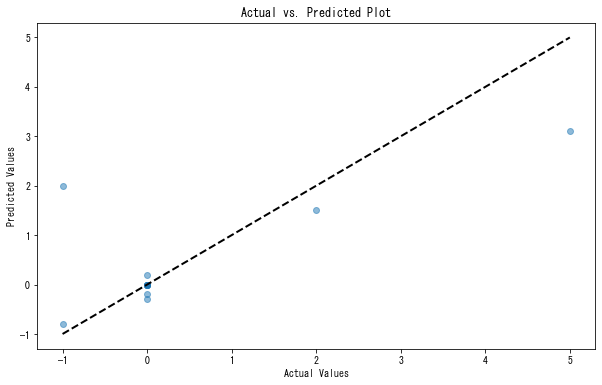

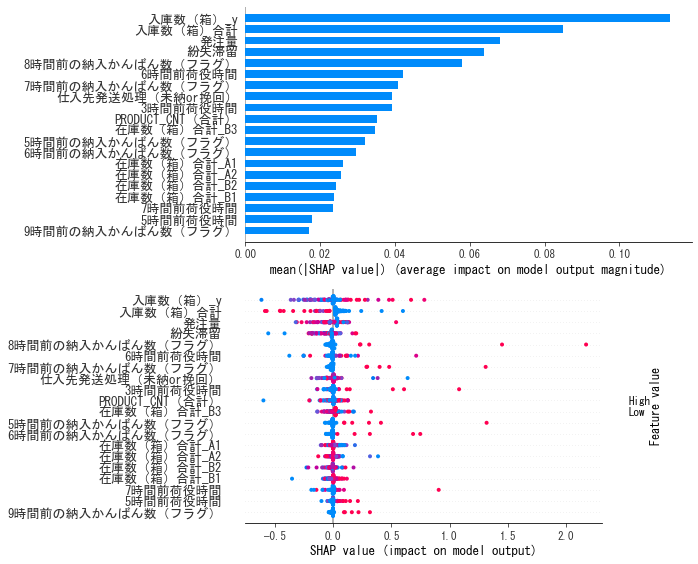

In [100]:
# フォント設定の変更（日本語対応のため）
mpl.rcParams['font.family'] = 'MS Gothic'

# データフレームXから100行目から300行目までのデータを選択
X_subset = X.iloc[0:100]
# モデルを使ってX_subsetから予測値を計算
y_pred_subset = rf_model.predict(X_subset)
# y_test_subset を用意する必要がある
# この例では単に y_test の対応する部分を選択することを仮定
y_test_subset = y_test.loc[X_subset.index]

# 実測値と予測値をプロット
plt.figure(figsize=(10, 6))
# 散布図で実測値と予測値をプロット
# alpha=0.5で点の透明度を設定して、データポイントが重なる場合に可視性を高める
plt.scatter(y_test_subset, y_pred_subset, alpha=0.5)
# 対角線を描画（完璧な予測を示す線）
# y_test_subsetの最小値から最大値までの線を引く
plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], 'k--', lw=2)
# X軸のラベルを設定
plt.xlabel('Actual Values')
# Y軸のラベルを設定
plt.ylabel('Predicted Values')
# タイトルを設定
plt.title('Actual vs. Predicted Plot')

# 図を表示
plt.show()

# SHAP計算
explainer = shap.TreeExplainer(rf_model, feature_dependence='tree_path_dependent', model_output='margin')
shap_values_subset = explainer.shap_values(X_subset)

# グリッドレイアウトの設定
fig = plt.figure(figsize=(20, 20))  # サイズを実用的な大きさに調整
gs = GridSpec(2, 1, figure=fig)

# SHAPサマリープロット
ax1 = fig.add_subplot(gs[0, 0])
shap.summary_plot(shap_values_subset, X_subset, feature_names=X.columns, plot_type="bar", show=False)

# 平均絶対SHAP値のバープロット
ax2 = fig.add_subplot(gs[1, 0])
shap.summary_plot(shap_values_subset, X_subset, feature_names=X.columns, show=False)

   Unnamed: 0           品番            YYYYMMDDH  発注かんばん数  1時間前の発注かんばん数  \
1           1  9031150A015  2023-10-01 01:00:00      0.0           0.0   
2           2  9031150A015  2023-10-01 02:00:00      0.0           0.0   
3           3  9031150A015  2023-10-01 03:00:00      0.0           0.0   
4           4  9031150A015  2023-10-01 04:00:00      0.0           0.0   
5           5  9031150A015  2023-10-01 05:00:00      0.0           0.0   

   2時間前の発注かんばん数  3時間前の発注かんばん数  4時間前の発注かんばん数  5時間前の発注かんばん数  6時間前の発注かんばん数  ...  \
1           0.0           0.0           0.0           0.0           0.0  ...   
2           0.0           0.0           0.0           0.0           0.0  ...   
3           0.0           0.0           0.0           0.0           0.0  ...   
4           0.0           0.0           0.0           0.0           0.0  ...   
5           0.0           0.0           0.0           0.0           0.0  ...   

   2時間前荷役時間  3時間前荷役時間  4時間前荷役時間  5時間前荷役時間  6時間前荷役時間  7時間前荷役時間  8時間前荷役時間  \

/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

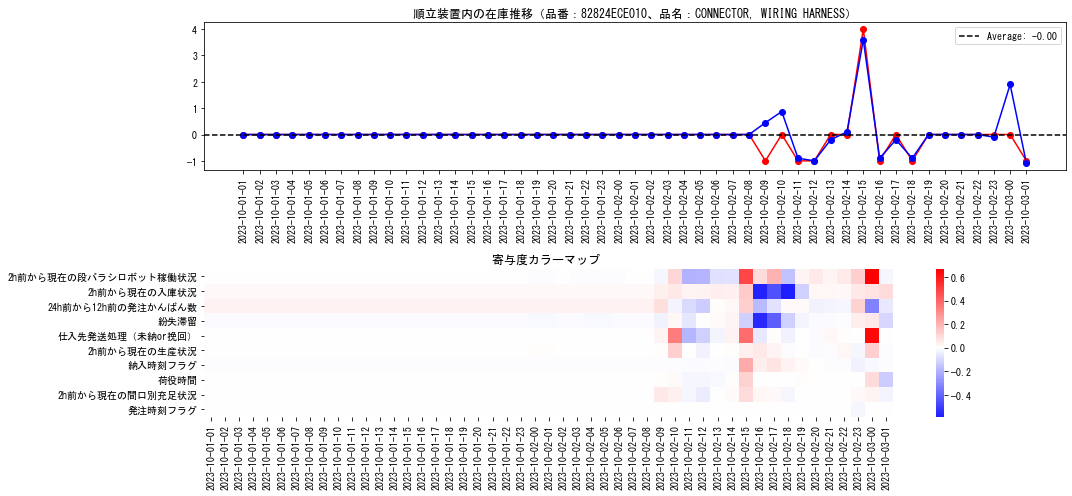

In [103]:
data = pd.read_csv(file_path_kanban_count_rackzaiko_data_flag_and_sum_and_teikibin_and_kumitaedaisu, encoding='shift_jis')

# 図の作成
plt.figure(figsize=(15, 7))

#df= data[data['品番'] == '019128GA010']
df=data.iloc[1:50]
print(df.head())

X_subset = X.iloc[1:50]
# モデルを使ってX_subsetから予測値を計算
y_pred_subset = rf_model.predict(X_subset)

df['YYYYMMDDH'] = pd.to_datetime(df['YYYYMMDDH'])
df.set_index('YYYYMMDDH', inplace=True)

df2 = df['在庫増減数']
print(df2.head())

# 折れ線グラフのサブプロット
plt.subplot(2, 1, 1) # (rows, columns, subplot number)
plt.plot(df2.index, df2, marker='o', linestyle='-', color='red')
plt.plot(df2.index, y_pred_subset, marker='o', linestyle='-', color='blue')
plt.title('順立装置内の在庫推移（品番：82824ECE010、品名：CONNECTOR, WIRING HARNESS）')
# データの平均値を計算
mean_value = y.mean()
# 平均線の追加
plt.axhline(y=mean_value, color='black', linestyle='--', label=f'Average: {mean_value:.2f}')
plt.legend()  # 凡例の表示
plt.xticks(ticks=df2.index, labels=df2.index.strftime('%Y-%m-%d-%H'), rotation=90)  # 日付フォーマットは必要に応じて調整
plt.tight_layout()

# SHAP値からデータフレームを作成
shap_df = pd.DataFrame(shap_values_subset, columns=X.columns)

# 並び替えた特徴量に基づいてデータフレームを再構成
#荷役時間集約
shap_df['荷役時間'] = (shap_df["3時間前荷役時間"]+shap_df["4時間前荷役時間"]+shap_df["5時間前荷役時間"]+shap_df["6時間前荷役時間"]+shap_df["7時間前荷役時間"]+shap_df["8時間前荷役時間"])/6
shap_df = shap_df.drop(['3時間前荷役時間', '4時間前荷役時間','5時間前荷役時間', '6時間前荷役時間','7時間前荷役時間', '8時間前荷役時間'], axis=1)
#
shap_df['発注時刻フラグ'] = shap_df["7時間前の発注かんばん数（フラグ）"] + \
                        shap_df["8時間前の発注かんばん数（フラグ）"] + \
                        shap_df["9時間前の発注かんばん数（フラグ）"] + \
                        shap_df["10時間前の発注かんばん数（フラグ）"] + \
                        shap_df["11時間前の発注かんばん数（フラグ）"] + \
                        shap_df["12時間前の発注かんばん数（フラグ）"] + \
                        shap_df["13時間前の発注かんばん数（フラグ）"] + \
                        shap_df["14時間前の発注かんばん数（フラグ）"] + \
                        shap_df["15時間前の発注かんばん数（フラグ）"] + \
                        shap_df["16時間前の発注かんばん数（フラグ）"] + \
                        shap_df["17時間前の発注かんばん数（フラグ）"] + \
                        shap_df["18時間前の発注かんばん数（フラグ）"] + \
                        shap_df["19時間前の発注かんばん数（フラグ）"] + \
                        shap_df["20時間前の発注かんばん数（フラグ）"] + \
                        shap_df["21時間前の発注かんばん数（フラグ）"] + \
                        shap_df["22時間前の発注かんばん数（フラグ）"]
shap_df['発注時刻フラグ'] = shap_df['発注時刻フラグ']/16
shap_df = shap_df.drop(['7時間前の発注かんばん数（フラグ）', 
          '8時間前の発注かんばん数（フラグ）', '9時間前の発注かんばん数（フラグ）', '10時間前の発注かんばん数（フラグ）', 
          '11時間前の発注かんばん数（フラグ）', '12時間前の発注かんばん数（フラグ）', '13時間前の発注かんばん数（フラグ）', 
          '14時間前の発注かんばん数（フラグ）', '15時間前の発注かんばん数（フラグ）', '16時間前の発注かんばん数（フラグ）', 
          '17時間前の発注かんばん数（フラグ）', '18時間前の発注かんばん数（フラグ）', '19時間前の発注かんばん数（フラグ）', 
          '20時間前の発注かんばん数（フラグ）', '21時間前の発注かんばん数（フラグ）', '22時間前の発注かんばん数（フラグ）'], axis=1)
#
shap_df['納入時刻フラグ'] = shap_df["5時間前の納入かんばん数（フラグ）"] + \
                          shap_df["6時間前の納入かんばん数（フラグ）"] + \
                          shap_df["7時間前の納入かんばん数（フラグ）"] + \
                          shap_df["8時間前の納入かんばん数（フラグ）"] + \
                          shap_df["9時間前の納入かんばん数（フラグ）"] + \
                          shap_df["10時間前の納入かんばん数（フラグ）"]
shap_df['納入時刻フラグ'] = shap_df['納入時刻フラグ']/6
shap_df = shap_df.drop(['5時間前の納入かんばん数（フラグ）', '6時間前の納入かんばん数（フラグ）', '7時間前の納入かんばん数（フラグ）',
          '8時間前の納入かんばん数（フラグ）', '9時間前の納入かんばん数（フラグ）', '10時間前の納入かんばん数（フラグ）'], axis=1)

shap_df['間口別充足状況'] = shap_df["在庫数（箱）合計_A1"] + \
                          shap_df["在庫数（箱）合計_A2"] + \
                          shap_df["在庫数（箱）合計_B1"] + \
                          shap_df["在庫数（箱）合計_B2"] + \
                          shap_df["在庫数（箱）合計_B3"] + \
                          shap_df["在庫数（箱）合計_B4"]
shap_df['間口別充足状況'] = shap_df['間口別充足状況']/6
shap_df = shap_df.drop(['在庫数（箱）合計_A1', '在庫数（箱）合計_A2', '在庫数（箱）合計_B1',
          '在庫数（箱）合計_B2', '在庫数（箱）合計_B3', '在庫数（箱）合計_B4'], axis=1)

#列名の変更
#shap_df = shap_df.rename(columns={'在庫数（箱）': '在庫数（箱）_1日の平均値'})

shap_df = shap_df.rename(columns={'発注量': '24h前から12h前の発注かんばん数'})
shap_df = shap_df.rename(columns={'入庫数（箱）_y': '2h前から現在の段バラシロボット稼働状況'})
shap_df = shap_df.rename(columns={'入庫数（箱）合計': '2h前から現在の入庫状況'})
shap_df = shap_df.rename(columns={'PRODUCT_CNT（合計）': '2h前から現在の生産状況'})
shap_df = shap_df.rename(columns={'間口別充足状況': '2h前から現在の間口別充足状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_A1': '2h前から現在の間口A1状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_A2': '2h前から現在の間口A2状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B1': '2h前から現在の間口B1状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B2': '2h前から現在の間口B2状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B3': '2h前から現在の間口B3状況'})
#shap_df = shap_df.rename(columns={'在庫数（箱）合計_B4': '2h前から現在の間口B4状況'})

# データフレームの平均SHAP値に基づいて特徴量を並び替え
shap_df_mean = shap_df.abs().mean().sort_values(ascending=False)
sorted_columns = shap_df_mean.index

shap_df_sorted = shap_df[sorted_columns]

dfdf = shap_df_sorted.iloc[1:50].T
    
# カラーマップ（ヒートマップ）のサブプロット
plt.subplot(2, 1, 2)
sns.heatmap(dfdf, cmap='bwr', cbar=True, center=0)  # Transpose the DataFrame
plt.title('寄与度カラーマップ ')
plt.xticks(np.arange(0.5, len(df2.index)), df2.index.strftime('%Y-%m-%d-%H'), rotation=90)
# 各セルに値を追記
#X = X.reindex(columns=shap_df_sorted.columns)
#XX = X.T
#for i in range(XX.shape[0]):
    #for j in range(XX.shape[1]):
        #formatted_value = "{:.1f}".format(XX.iloc[i, j])
        #text = plt.text(j+0.5, i+0.5, formatted_value,
                       #ha="center", va="center", color="black")
plt.tight_layout()

filename = 'モ'+ '.png'
plt.savefig(filename)

In [137]:
dfdf.head(30)

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
入庫数（箱）合計,0.660477,-0.438233,-0.207564,-0.075008,-0.010429,0.035367,0.058760,0.038038,0.062454,0.048523,...,-0.166120,-0.023304,0.035832,0.030715,0.046737,0.041870,0.064001,0.074120,0.148419,0.230255
納入量,-0.066973,-0.190720,0.026849,-0.098019,0.013303,-0.056218,-0.010554,-0.050245,0.062554,-0.191291,...,-0.055473,-0.046547,-0.011172,0.043950,0.079831,-0.025758,-0.135748,-0.041032,-0.042920,-0.001170
発注量,0.186944,-0.090210,-0.040452,0.006995,0.041634,0.027289,0.175604,-0.168696,0.021890,-0.113671,...,-0.027880,-0.000031,-0.012410,-0.005695,0.015441,-0.032990,-0.057185,-0.035508,-0.010220,0.018302
8時間前の納入かんばん数（フラグ）,1.790065,-0.010342,-0.004845,-0.008523,-0.004504,-0.018012,-0.017308,-0.009798,-0.025383,-0.037759,...,-0.010797,-0.013458,-0.015269,-0.016707,-0.011063,-0.010647,-0.028091,-0.020173,-0.013114,0.762401
PRODUCT_CNT（合計）,0.245743,-0.090155,0.023642,-0.150631,0.065851,-0.086007,-0.011894,-0.062434,-0.189337,-0.094151,...,0.014056,-0.019808,0.015356,0.181636,-0.124276,0.020170,-0.007922,-0.211852,0.031619,0.043859
6時間前荷役時間,0.035011,-0.036810,-0.043122,-0.075979,-0.000989,-0.017812,-0.086408,0.000192,-0.019698,-0.025844,...,0.025148,-0.015094,-0.016947,-0.010669,0.070570,-0.012934,-0.204491,-0.049370,-0.044373,0.047528
7時間前の納入かんばん数（フラグ）,0.005886,-0.011135,-0.008668,-0.011441,-0.014316,-0.024952,-0.011316,-0.015571,-0.032948,-0.030158,...,-0.005412,-0.011849,-0.027202,-0.014117,-0.013910,-0.019443,-0.014156,-0.022588,0.549617,-0.012441
3時間前荷役時間,0.479333,-0.010807,0.012131,-0.009979,0.031090,-0.014468,0.019512,-0.255659,-0.072500,-0.016613,...,-0.003842,0.035309,-0.056204,-0.043370,0.006108,0.023198,-0.043435,-0.066994,-0.128605,-0.032294
紛失滞留,0.086308,-0.129076,0.017227,-0.052931,-0.043619,0.023885,0.002337,-0.112937,-0.074244,-0.033241,...,-0.000091,-0.009213,0.009378,0.031715,0.020732,0.011119,-0.004304,-0.027138,-0.031547,0.013663
5時間前の納入かんばん数（フラグ）,-0.011780,-0.016270,-0.005539,-0.019818,0.005890,-0.000807,-0.004850,-0.050146,-0.004709,-0.025274,...,-0.004319,-0.011821,-0.006255,-0.004042,-0.076387,-0.002224,0.224584,-0.017296,-0.005710,-0.010178


In [76]:
#検証用
trydata = data

#データフレームの長さを確認したい
#print(len(trydata))

data['在庫増減数'].head()

# データフレームの各列のデータ型を確認
#trydata.dtypes
#データフレームのカラム表示
#trydata.columns.tolist()

#print(len(kanban_count_data))
#print(len(rackzaiko_data))
#print(len(merged_data_for_kanban_and_rackzaiko))
#merged_data_for_flag_and_sum.columns.tolist()#データフレームのカラム表示
#print(rackzaiko_data.head(500))
#print(kanban_count_data.head())
# 確認のため、データフレームの先頭数行を表示
#filtered_data = trydata[trydata['品番'] == 'G1163ECE010']
#filtered_data[['品番','1時間単位時刻' ,'発注かんばん数','1時間前の発注かんばん数','2時間前の発注かんばん数','3時間前の発注かんばん数','4時間前の発注かんばん数'
              #,'発注かんばん数（フラグ）','1時間前の発注かんばん数（フラグ）','2時間前の発注かんばん数（フラグ）','3時間前の発注かんばん数（フラグ）','4時間前の発注かんばん数（フラグ）']].head(50)
#filtered_data[['品番','YYYYMMDDH' ,'発注かんばん数','4時間前の発注かんばん数'
              #,'発注かんばん数（フラグ）','4時間前の発注かんばん数（フラグ）','発注量']].head(50)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 在庫増減数, dtype: float64

In [ ]:
#課題リスト
・荷役時間が数時間とかある。